<a href="https://colab.research.google.com/github/Yarosuravu/Yarosuravu/blob/main/MLP_CH4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

# відомі коефіцієнти A, B
A, B = 1.0, 0.005

# генеруємо концентрації від 0 до 5000 ppm
C = np.linspace(0, 5000, 1000)

# чистий сигнал еталону (можемо нормувати I_ref=1)
I_ref = 1.0

# модельні сигнали вимірювання
I_meas = I_ref * A * np.exp(-B * C)

# додаємо невеликий шум, імітуючи погрішності сенсорів (~±3%)
noise = np.random.normal(1.0, 0.03, size=C.shape)
I_meas_noisy = I_meas * noise

# готуємо DataFrame
df = pd.DataFrame({
    'ratio': I_meas_noisy / I_ref,
    'log_ratio': np.log(I_meas_noisy / I_ref),
    'concentration': C
})
df.to_csv('synthya_data.csv', index=False)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Припустимо, df — ваш DataFrame з ratio, log_ratio, concentration
X = df[['ratio', 'log_ratio']].values
y = df['concentration'].values.reshape(-1, 1)

# Нормалізація
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Розбивка
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# Побудова моделі
model = Sequential([
    Dense(16, activation='relu', input_shape=(2,)),
    Dense(8, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Навчання
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop]
)

history_df = pd.DataFrame({
    'epoch': list(range(1, len(history.history['loss']) + 1)),
    'train_loss': history.history['loss'],
    'val_loss': history.history['val_loss']
})
# Повернення прогнозу в оригінальний масштаб
def predict_concentration(ratio):
    x = np.array([[ratio, np.log(ratio)]])
    x_scaled = scaler_X.transform(x)
    y_scaled = model.predict(x_scaled)
    return scaler_y.inverse_transform(y_scaled)[0,0]



# Зберегти у CSV
history_df.to_csv('training_metrics.csv', index=False)

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2657 - val_loss: 0.1809
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1624 - val_loss: 0.1390
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1225 - val_loss: 0.1092
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0962 - val_loss: 0.0809
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0764 - val_loss: 0.0558
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0488 - val_loss: 0.0362
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0290 - val_loss: 0.0218
Epoch 8/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0181 - val_loss: 0.0128
Epoch 9/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112 - val_loss: 0.0073
Epoch 10/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 - val_loss: 0.0044
Epoch 11/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 12/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - val_lo

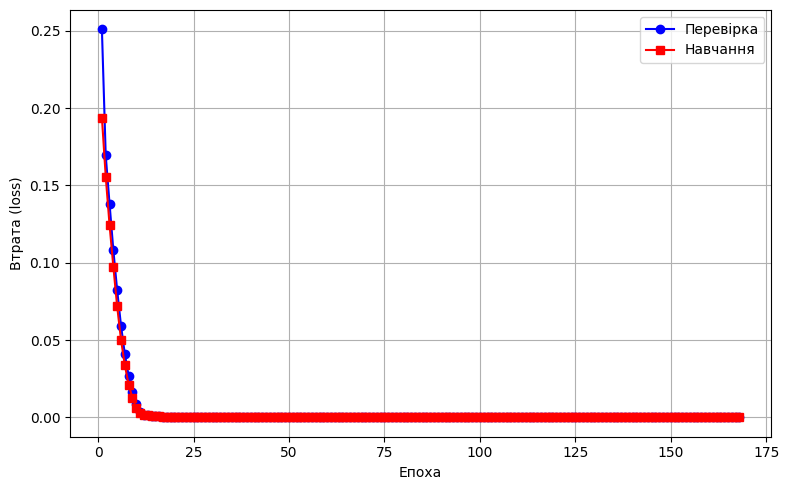

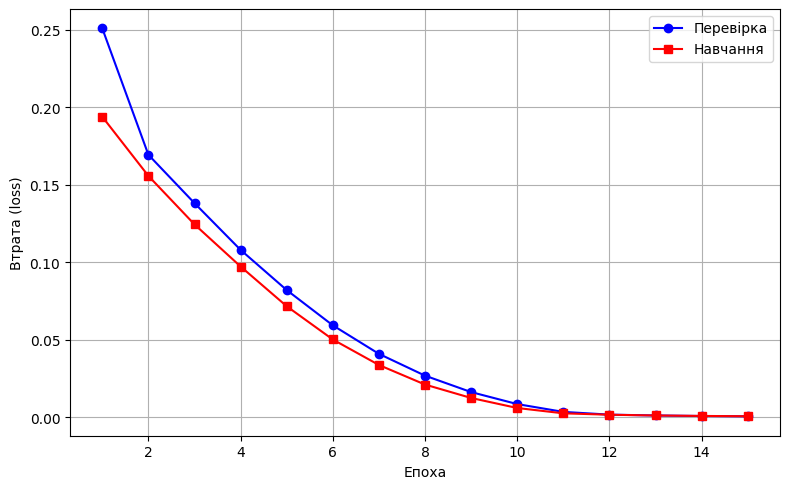

In [ ]:
import matplotlib.pyplot as plt

# Отримуємо дані з історії навчання
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, 169)
# Побудова графіку
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'b-o', label='Перевірка')
plt.plot(epochs, val_loss, 'r-s', label='Навчання')
plt.title('')
plt.xlabel('Епоха')
plt.ylabel('Втрата (loss)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Беремо тільки перші 15 епох
epochs = range(1, min(16, len(loss) + 1))

# Побудова графіку
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss[:15], 'b-o', label='Перевірка')
plt.plot(epochs, val_loss[:15], 'r-s', label='Навчання')
plt.title('')
plt.xlabel('Епоха')
plt.ylabel('Втрата (loss)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
# Приклад: масиви довжиною N
measured_ratio = df['ratio'].values         # виміряне відношення I_meas / I_ref
true_concentration = df['concentration'].values     # відомі концентрації, у ppm


In [ ]:
# Отримуємо вектор прогнозів для всіх значень ratio
predicted_concentration = np.array([
    predict_concentration(r) for r in measured_ratio
])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

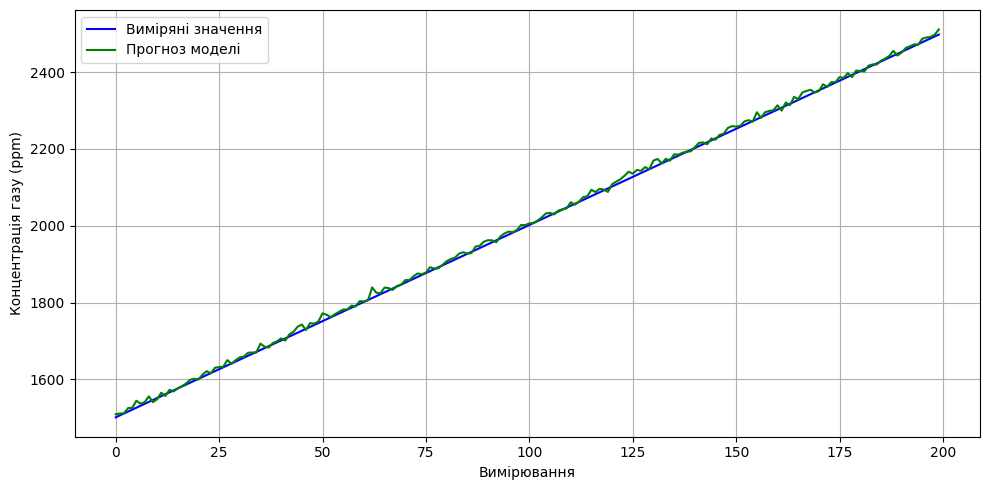

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Порівняння концентрацій
plt.figure(figsize=(10, 5))
plt.plot(true_concentration[300:500], label='Виміряні значення', color='blue')
plt.plot(predicted_concentration[300:500], label='Прогноз моделі', color='green', linestyle='-')
plt.xlabel('Вимірювання')
plt.ylabel('Концентрація газу (ppm)')
#plt.title('Порівняння: теоретичні vs прогнозовані значення')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




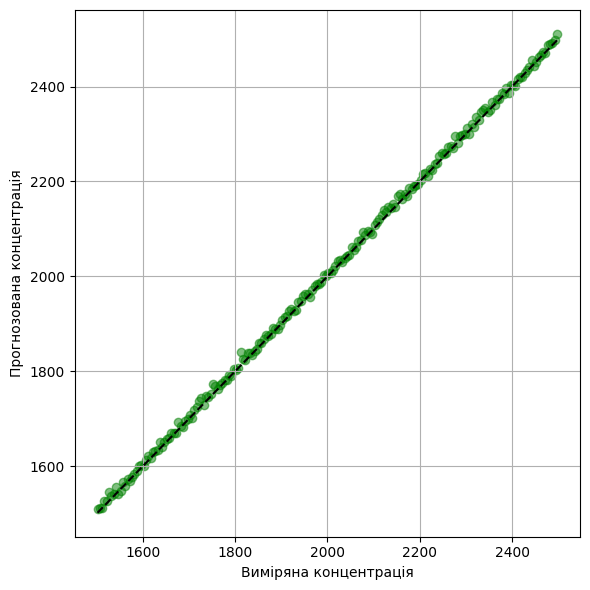

In [ ]:
plt.figure(figsize=(6,6))
y_true=true_concentration[300:500]
y_pred=predicted_concentration[300:500]
plt.scatter(y_true, y_pred, c='green', alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'k--')
plt.xlabel('Виміряна концентрація')
plt.ylabel('Прогнозована концентрація')
#plt.title('Розкид прогнозів (ідеальна пряма = точний збіг)')
plt.grid(True)
plt.tight_layout()
plt.show()


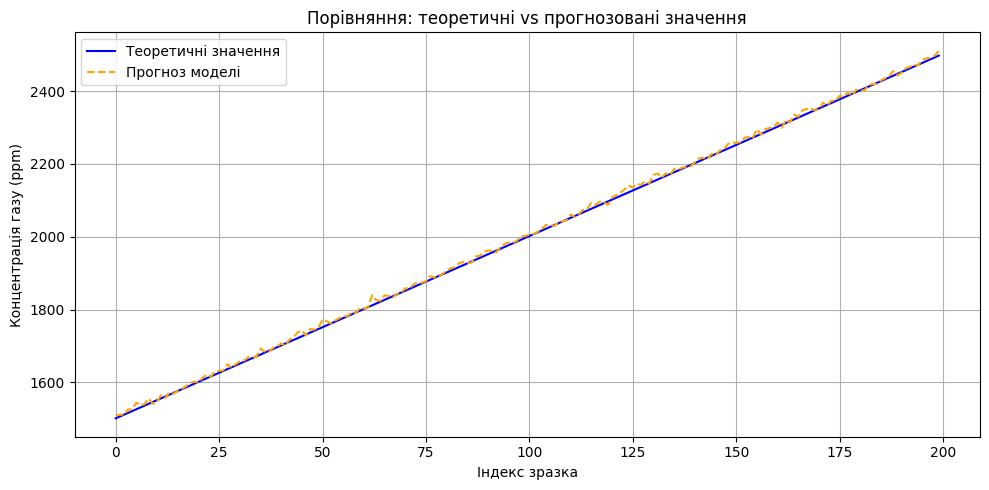

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Порівняння концентрацій
plt.figure(figsize=(10, 5))
plt.plot(y_true, label='Теоретичні значення', color='blue', linestyle='-')
plt.plot(y_pred, label='Прогноз моделі', color='orange', linestyle='--')
plt.xlabel('Індекс зразка')
plt.ylabel('Концентрація газу (ppm)')
plt.title('Порівняння: теоретичні vs прогнозовані значення')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-17-2447843553.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


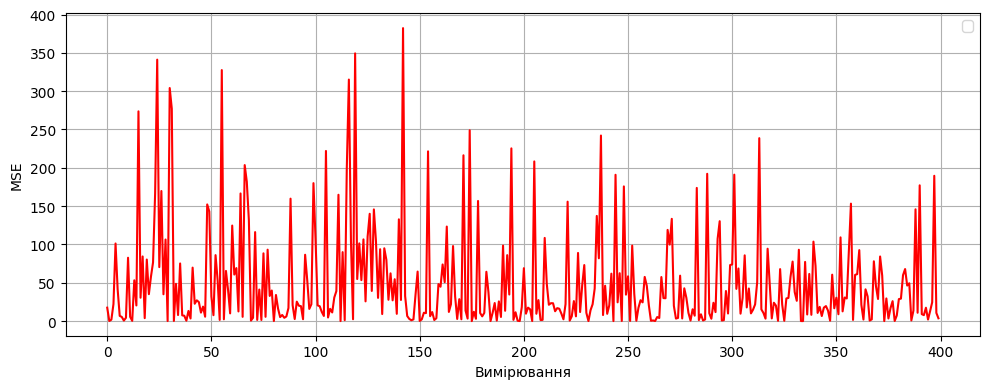

Загальне значення MSE: 86.463 ppm²


In [ ]:
errors = (true_concentration - predicted_concentration) ** 2

plt.figure(figsize=(10, 4))
plt.plot(errors[400:800], color='red')
plt.xlabel('Вимірювання')
plt.ylabel('MSE')
#plt.title('MSE між прогнозом та еталоном')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Загальна помилка
mse = mean_squared_error(true_concentration, predicted_concentration)
print(f"Загальне значення MSE: {mse:.3f} ppm²")

# Для валідаційної вибірки (можна аналогічно для тренувальної)
results_df = pd.DataFrame({
    'true_concentration': true_concentration.flatten(),
    'predicted_concentration': predicted_concentration.flatten(),
    'mse': errors.flatten()
})

# Зберегти у CSV
results_df.to_csv('validation_predictions.csv', index=False)

/tmp/ipython-input-19-430951818.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


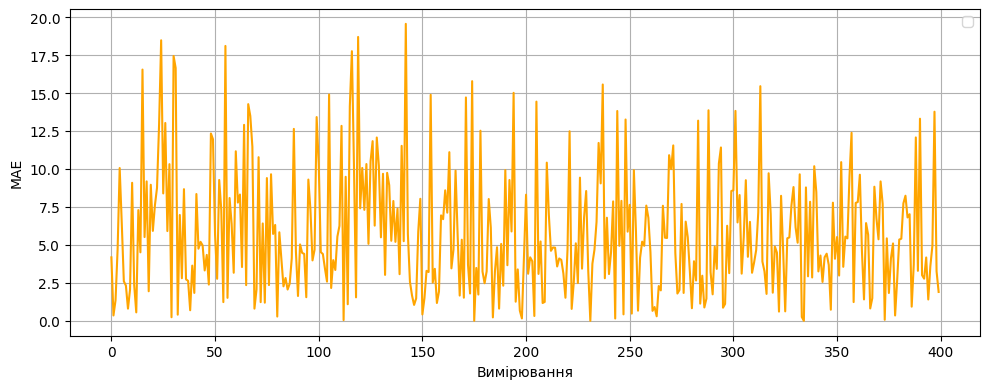

Загальне значення MAE: 7.119 ppm


In [ ]:
from sklearn.metrics import mean_absolute_error

# Розрахунок абсолютної похибки для кожного зразка
errors = np.abs(true_concentration - predicted_concentration)

plt.figure(figsize=(10, 4))
plt.plot(errors[400:800], color='orange')
plt.xlabel('Вимірювання')
plt.ylabel('MAE')
#plt.title('MAE між прогнозом та еталоном')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Загальна середня абсолютна похибка
mae = mean_absolute_error(true_concentration, predicted_concentration)
print(f"Загальне значення MAE: {mae:.3f} ppm")


results_df = pd.DataFrame({
    'true_concentration': true_concentration.flatten(),
    'predicted_concentration': predicted_concentration.flatten(),
    'mae': errors.flatten()
})

# Зберегти у CSV
results_df.to_csv('validation_predictions_mae.csv', index=False)

In [9]:
plt.figure(figsize=(6, 6))
plt.scatter(true_concentration, predicted_concentration, c='blue', alpha=0.6, label='Прогнози моделі')
plt.plot([min(true_concentration), max(true_concentration)],
         [min(true_concentration), max(true_concentration)],
         'k--', label='Вимірювання')
plt.xlabel('Теоретична концентрація (ppm)')
plt.ylabel('Прогнозована концентрація (ppm)')
plt.title('Розкид прогнозів MLP')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'true_concentration' is not defined

<Figure size 600x600 with 0 Axes>

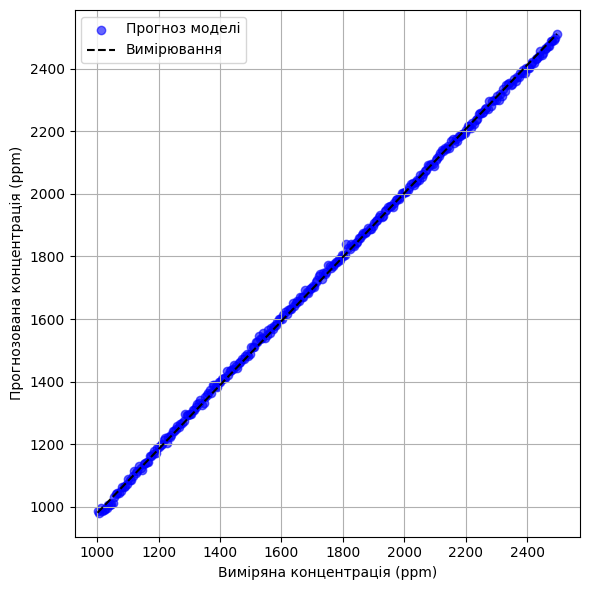

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
y_true=true_concentration[200:500]
y_pred=predicted_concentration[200:500]
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred,
            c='blue', alpha=0.6, label='Прогноз моделі')
plt.plot([min(y_true), max(y_true)],
         [min(y_pred), max(y_pred)],
         'k--', label='Вимірювання')
plt.xlabel('Виміряна концентрація (ppm)')
plt.ylabel('Прогнозована концентрація (ppm)')
#plt.title('Графік відповідності: істина vs прогноз MLP')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Симуляція рівномірного діапазону ratio (наприклад, від 0.1 до 1.0)
# В такому діапазоні ratio змінюється при зростанні концентрації газу
ratio_range = np.linspace(0.1, 1.0, 200)  # 200 точок від 0.1 до 1.0


In [ ]:
# Модельна функція, яка приймає ratio і повертає концентрацію
predicted_concentration_curve = np.array([
    predict_concentration(r) for r in ratio_range
])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━

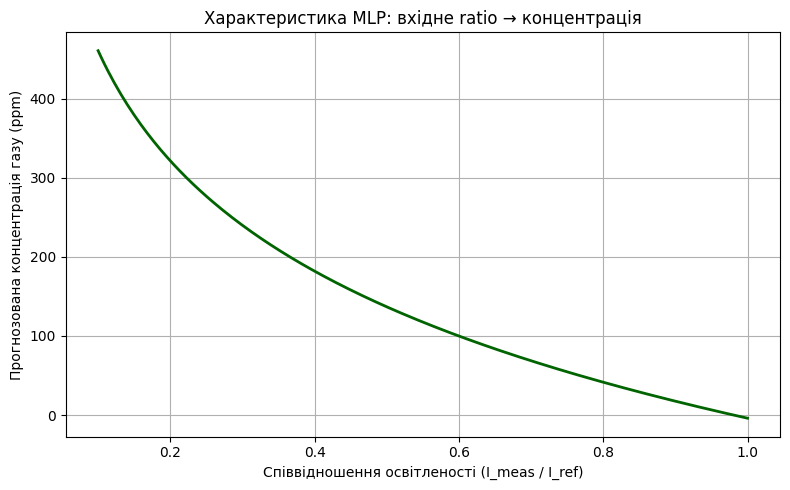

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(ratio_range, predicted_concentration_curve, color='darkgreen', linewidth=2)
plt.xlabel('Співвідношення освітленості (I_meas / I_ref)')
plt.ylabel('Прогнозована концентрація газу (ppm)')
plt.title('Характеристика MLP: вхідне ratio → концентрація')
plt.grid(True)
plt.tight_layout()
plt.show()


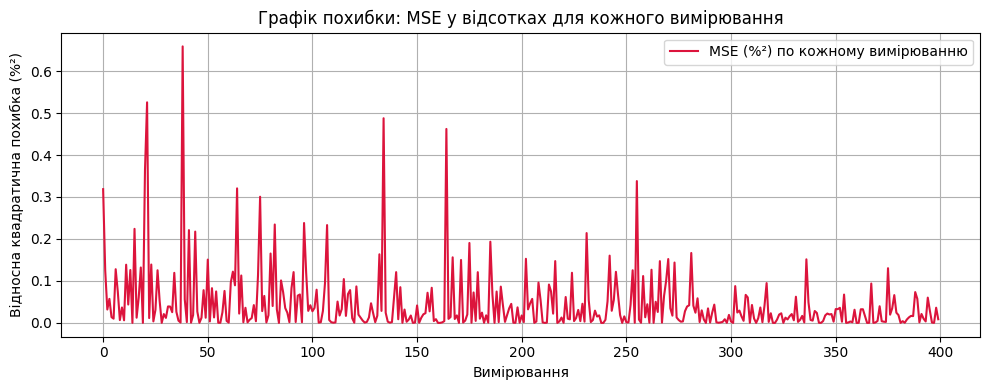

Середнє значення MSE у відсотках: 0.05 %²


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Обчислення відносної похибки (%)
relative_errors = 100 * (predicted_concentration[400:800] - true_concentration[400:800]) / true_concentration[400:800]

# Квадрати цієї похибки — відносний MSE у %
relative_squared_errors = relative_errors ** 2

# Графік
plt.figure(figsize=(10, 4))
plt.plot(relative_squared_errors, color='crimson', label='MSE (%²) по кожному вимірюванню')
plt.xlabel('Вимірювання')
plt.ylabel('Відносна квадратична похибка (%²)')
plt.title('Графік похибки: MSE у відсотках для кожного вимірювання')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Обчислюємо середнє значення
mean_relative_mse = np.mean(relative_squared_errors)
print(f"Середнє значення MSE у відсотках: {mean_relative_mse:.2f} %²")


In [ ]:
absolute_percentage_errors = np.abs(relative_errors)
mean_ape = np.mean(absolute_percentage_errors)
print(f"Середня абсолютна похибка (MAPE): {mean_ape:.2f} %")


Середня абсолютна похибка (MAPE): 0.16 %


Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.3335 - mae: 0.5055 - val_loss: 0.2064 - val_mae: 0.3584
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1997 - mae: 0.3633 - val_loss: 0.1638 - val_mae: 0.3371
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1438 - mae: 0.3115 - val_loss: 0.1398 - val_mae: 0.3170
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1333 - mae: 0.3075 - val_loss: 0.1173 - val_mae: 0.2902
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1095 - mae: 0.2750 - val_loss: 0.0966 - val_mae: 0.2640
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0918 - mae: 0.2570 - val_loss: 0.0772 - val_mae: 0.2351
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0716 - mae: 0.2232 - val_loss: 0.0596 - val_mae: 0.2051
Epoch 8/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0605 - mae: 0.2084 - val_loss: 0.0428 - val_mae: 0.1711
Epoch 9/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0400 - mae: 0.

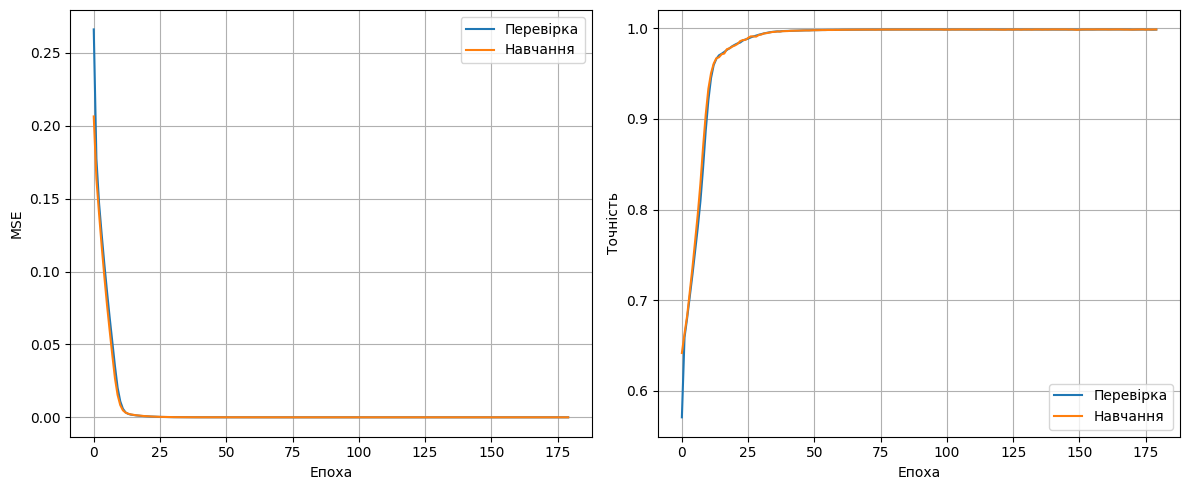

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

# Припустимо, df — ваш DataFrame з ratio, log_ratio, concentration
X = df[['ratio', 'log_ratio']].values
y = df['concentration'].values.reshape(-1, 1)

# Нормалізація
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Розбивка
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

# Побудова моделі
model = Sequential([
    Dense(16, activation='relu', input_shape=(2,)),
    Dense(8, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mae'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Навчання
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop]
)

# Побудова графіків
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Перевірка')
plt.plot(history.history['val_loss'], label='Навчання')
#plt.title('MSE')
plt.xlabel('Епоха')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

# Точність (навпаки до MAE)
plt.subplot(1, 2, 2)
train_accuracy = 1 - np.array(history.history['mae'])
val_accuracy = 1 - np.array(history.history['val_mae'])
plt.plot(train_accuracy, label='Перевірка')
plt.plot(val_accuracy, label='Навчання')
#plt.title('Точність')
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Повернення прогнозу в оригінальний масштаб
def predict_concentration(ratio):
    x = np.array([[ratio, np.log(ratio)]])
    x_scaled = scaler_X.transform(x)
    y_scaled = model.predict(x_scaled)
    return scaler_y.inverse_transform(y_scaled)[0,0]


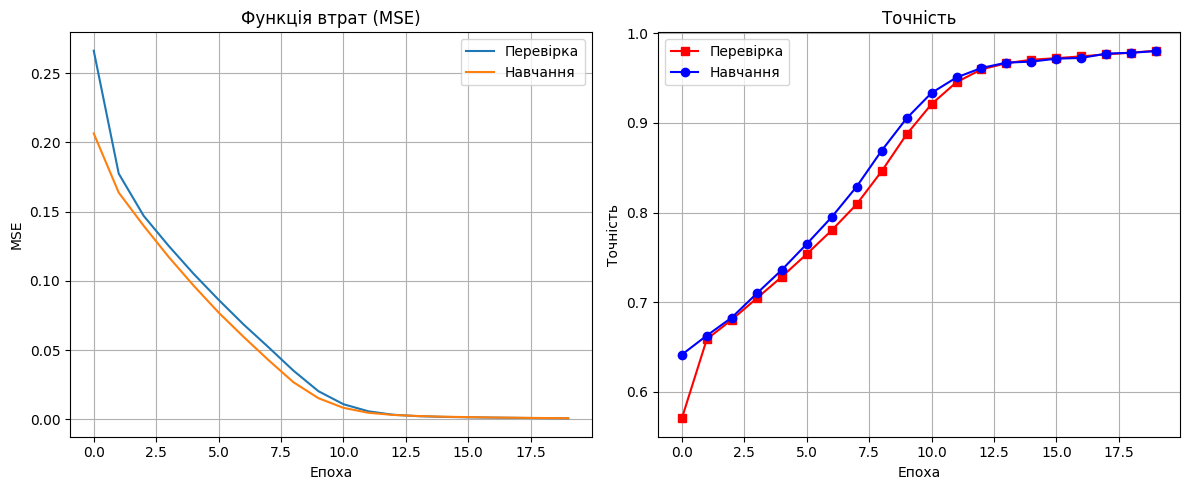

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Точність на навчальній вибірці (±10 ppm): 82.88%
Точність на перевірочній вибірці (±10 ppm): 87.00%


In [ ]:
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
#from tensorflow.keras.callbacks import EarlyStopping
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import MinMaxScaler
#import matplotlib.pyplot as plt
#import numpy as np

# Припустимо, df — ваш DataFrame з ratio, log_ratio, concentration
X = df[['ratio', 'log_ratio']].values
y = df['concentration'].values.reshape(-1, 1)

# Нормалізація
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Розбивка
#X_train, X_val, y_train, y_val = train_test_split(
#    X_scaled, y_scaled, test_size=0.2, random_state=42
#)

# Побудова моделі
#model = Sequential([
#    Dense(16, activation='relu', input_shape=(2,)),
#    Dense(8, activation='relu'),
#    Dense(1, activation='linear')
#])

#model.compile(optimizer='adam',
#              loss='mse',
#              metrics=['mae'])

# Early stopping
#early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Навчання
#history = model.fit(
#    X_train, y_train,
#    validation_data=(X_val, y_val),
#    epochs=200,
#    batch_size=32,
#    callbacks=[early_stop]
#)

# Побудова графіків (перші 20 епох)
epochs_to_display = 20

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'][:epochs_to_display], label='Перевірка')
plt.plot(history.history['val_loss'][:epochs_to_display], label='Навчання')
plt.title('Функція втрат (MSE)')
plt.xlabel('Епоха')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

# Точність (навпаки до MAE)
plt.subplot(1, 2, 2)
train_accuracy = 1 - np.array(history.history['mae'])[:epochs_to_display]
val_accuracy = 1 - np.array(history.history['val_mae'])[:epochs_to_display]
plt.plot(train_accuracy, 'r-s', label='Перевірка')
plt.plot(val_accuracy, 'b-o',  label='Навчання')
plt.title('Точність')
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Оцінка точності моделі у відсотках влучання в заданий допуск
def evaluate_accuracy_in_tolerance(X_data, y_true_scaled, tolerance_ppm):
    y_true = scaler_y.inverse_transform(y_true_scaled)
    y_pred_scaled = model.predict(X_data)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    errors = np.abs(y_pred - y_true)
    correct = (errors <= tolerance_ppm).astype(int)
    accuracy_percent = 100 * correct.mean()
    return accuracy_percent

# Приклад: оцінити точність влучання у допуск ±10 ppm
train_accuracy_pct = evaluate_accuracy_in_tolerance(X_train, y_train, tolerance_ppm=10)
val_accuracy_pct = evaluate_accuracy_in_tolerance(X_val, y_val, tolerance_ppm=10)

print(f"Точність на навчальній вибірці (±10 ppm): {train_accuracy_pct:.2f}%")
print(f"Точність на перевірочній вибірці (±10 ppm): {val_accuracy_pct:.2f}%")

# Повернення прогнозу в оригінальний масштаб
def predict_concentration(ratio):
    x = np.array([[ratio, np.log(ratio)]])
    x_scaled = scaler_X.transform(x)
    y_scaled = model.predict(x_scaled)
    return scaler_y.inverse_transform(y_scaled)[0,0]


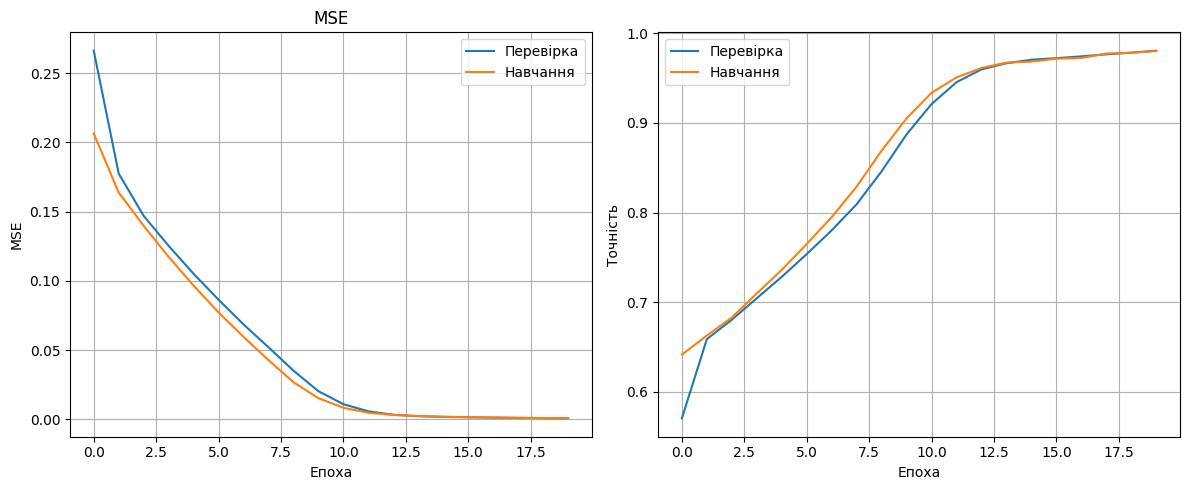

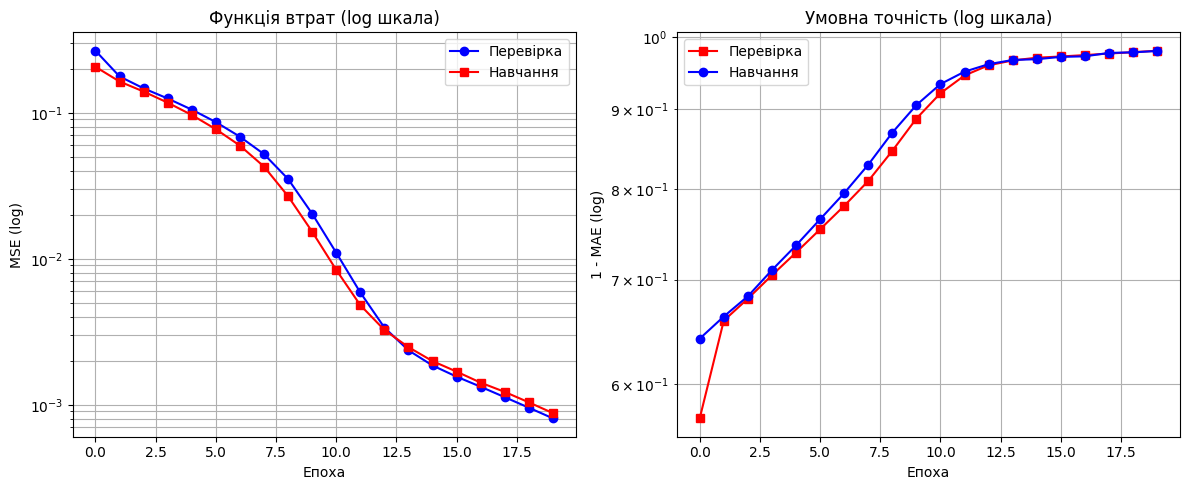

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Точність на тренувальній вибірці (±10 ppm): 82.88%
Точність на валідаційній вибірці (±10 ppm): 87.00%


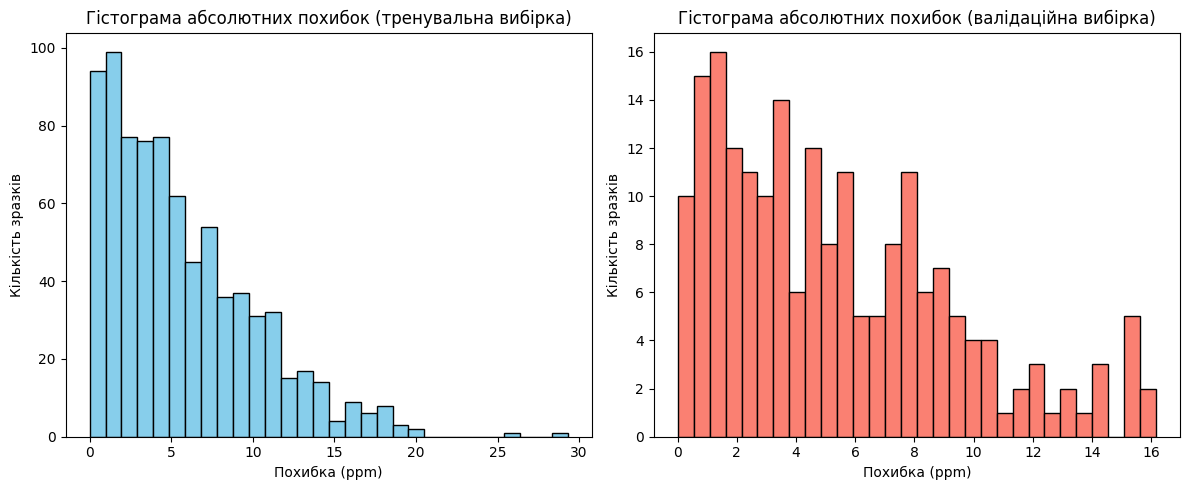

In [ ]:
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
#from tensorflow.keras.callbacks import EarlyStopping
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import MinMaxScaler
#import matplotlib.pyplot as plt
#import numpy as np

# Припустимо, df — ваш DataFrame з ratio, log_ratio, concentration
X = df[['ratio', 'log_ratio']].values
y = df['concentration'].values.reshape(-1, 1)

# Нормалізація
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Розбивка
#X_train, X_val, y_train, y_val = train_test_split(
#    X_scaled, y_scaled, test_size=0.2, random_state=42
#)

# Побудова моделі
#model = Sequential([
#    Dense(16, activation='relu', input_shape=(2,)),
#    Dense(8, activation='relu'),
#    Dense(1, activation='linear')
#])

#model.compile(optimizer='adam',
#              loss='mse',
#              metrics=['mae'])

# Early stopping
#early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Навчання
#history = model.fit(
#    X_train, y_train,
#    validation_data=(X_val, y_val),
#    epochs=200,
#    batch_size=32,
#    callbacks=[early_stop]
#)

# Побудова графіків (перші 20 епох)
epochs_to_display = 20

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'][:epochs_to_display], label='Перевірка')
plt.plot(history.history['val_loss'][:epochs_to_display], label='Навчання')
plt.title('MSE')
plt.xlabel('Епоха')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

# Точність (навпаки до MAE)
plt.subplot(1, 2, 2)
train_accuracy = 1 - np.array(history.history['mae'])[:epochs_to_display]
val_accuracy = 1 - np.array(history.history['val_mae'])[:epochs_to_display]
plt.plot(train_accuracy, label='Перевірка')
plt.plot(val_accuracy, label='Навчання')
#plt.title('Точність')
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Додатково: логарифмічні графіки
plt.figure(figsize=(12, 5))

# Log Loss
plt.subplot(1, 2, 1)
plt.semilogy(history.history['loss'][:epochs_to_display], 'b-o',label='Перевірка')
plt.semilogy(history.history['val_loss'][:epochs_to_display], 'r-s', label='Навчання')
plt.title('Функція втрат (log шкала)')
plt.xlabel('Епоха')
plt.ylabel('MSE (log)')
plt.legend()
plt.grid(True, which="both")

# Log Accuracy (1 - MAE)
plt.subplot(1, 2, 2)
plt.semilogy(train_accuracy, 'r-s', label='Перевірка')
plt.semilogy(val_accuracy, 'b-o', label='Навчання')
plt.title('Умовна точність (log шкала)')
plt.xlabel('Епоха')
plt.ylabel('1 - MAE (log)')
plt.legend()
plt.grid(True, which="both")

plt.tight_layout()
plt.show()

# Оцінка точності моделі у відсотках влучання в заданий допуск
def evaluate_accuracy_in_tolerance(X_data, y_true_scaled, tolerance_ppm):
    y_true = scaler_y.inverse_transform(y_true_scaled)
    y_pred_scaled = model.predict(X_data)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    errors = np.abs(y_pred - y_true)
    correct = (errors <= tolerance_ppm).astype(int)
    accuracy_percent = 100 * correct.mean()
    return accuracy_percent, y_true, y_pred, errors

# Приклад: оцінити точність влучання у допуск ±10 ppm
train_accuracy_pct, y_true_train, y_pred_train, errors_train = evaluate_accuracy_in_tolerance(X_train, y_train, tolerance_ppm=10)
val_accuracy_pct, y_true_val, y_pred_val, errors_val = evaluate_accuracy_in_tolerance(X_val, y_val, tolerance_ppm=10)

print(f"Точність на тренувальній вибірці (±10 ppm): {train_accuracy_pct:.2f}%")
print(f"Точність на валідаційній вибірці (±10 ppm): {val_accuracy_pct:.2f}%")

# Побудова гістограм похибок
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(errors_train, bins=30, color='skyblue', edgecolor='black')
plt.title('Гістограма абсолютних похибок (тренувальна вибірка)')
plt.xlabel('Похибка (ppm)')
plt.ylabel('Кількість зразків')

plt.subplot(1, 2, 2)
plt.hist(errors_val, bins=30, color='salmon', edgecolor='black')
plt.title('Гістограма абсолютних похибок (валідаційна вибірка)')
plt.xlabel('Похибка (ppm)')
plt.ylabel('Кількість зразків')

plt.tight_layout()
plt.show()

# Повернення прогнозу в оригінальний масштаб
def predict_concentration(ratio):
    x = np.array([[ratio, np.log(ratio)]])
    x_scaled = scaler_X.transform(x)
    y_scaled = model.predict(x_scaled)
    return scaler_y.inverse_transform(y_scaled)[0,0]


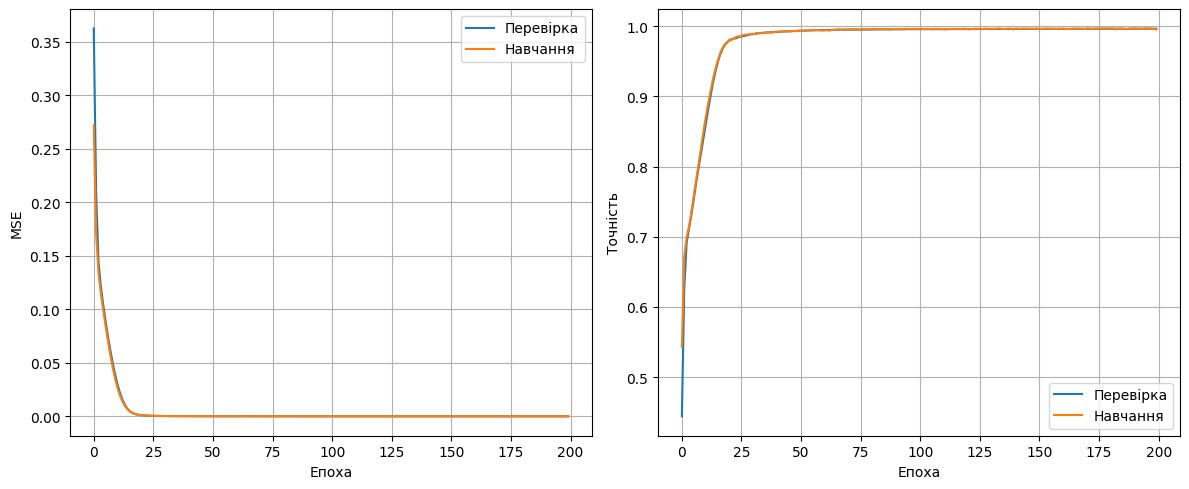

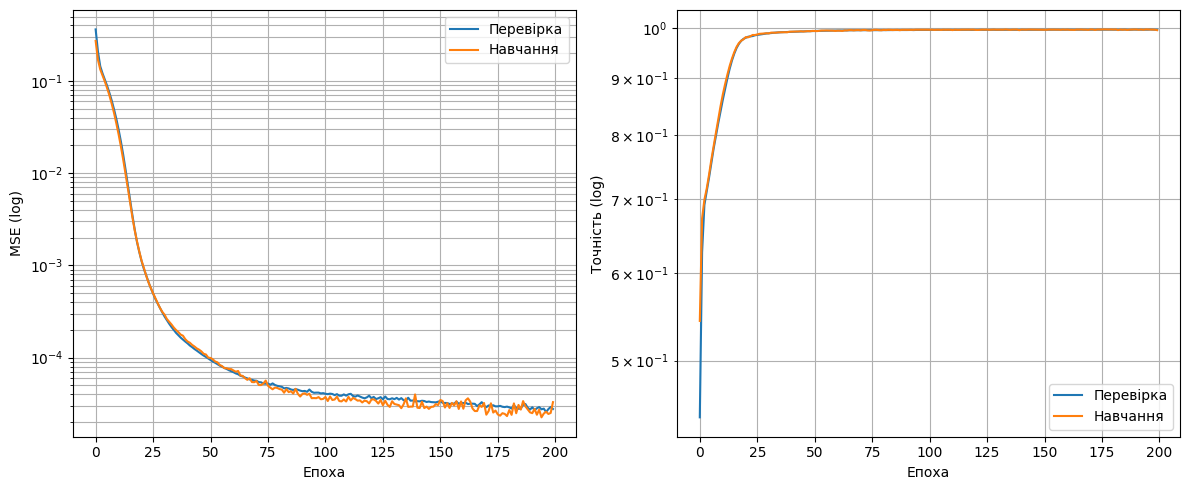

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Точність на навчальній вибірці (±10 ppm): 46.12%
Точність на перевірочній вибірці (±10 ppm): 52.00%


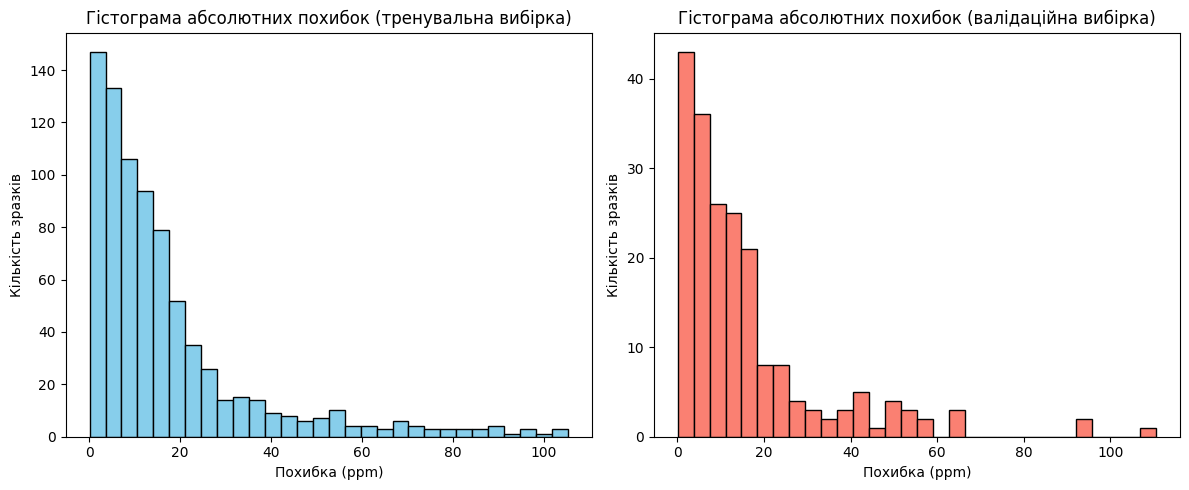

In [ ]:
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
#from tensorflow.keras.callbacks import EarlyStopping
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import MinMaxScaler
#import matplotlib.pyplot as plt
#import numpy as np

# Припустимо, df — ваш DataFrame з ratio, log_ratio, concentration
X = df[['ratio', 'log_ratio']].values
y = df['concentration'].values.reshape(-1, 1)

# Нормалізація
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Розбивка
#X_train, X_val, y_train, y_val = train_test_split(
#    X_scaled, y_scaled, test_size=0.2, random_state=42
#)

# Побудова моделі
#model = Sequential([
#    Dense(16, activation='relu', input_shape=(2,)),
#    Dense(8, activation='relu'),
#    Dense(1, activation='linear')
#])

#model.compile(optimizer='adam',
#              loss='mse',
#              metrics=['mae'])

# Early stopping
#early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Навчання
#history = model.fit(
#    X_train, y_train,#
#    validation_data=(X_val, y_val),
#    epochs=200,
#    batch_size=32,
#    callbacks=[early_stop]
#)

# Побудова графіків навчання для всіх епох
train_accuracy_all = 1 - np.array(history.history['mae'])
val_accuracy_all = 1 - np.array(history.history['val_mae'])

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Перевірка')
plt.plot(history.history['val_loss'], label='Навчання')
#plt.title('Функція втрат (MSE) — всі епохи')
plt.xlabel('Епоха')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_all, label='Перевірка')
plt.plot(val_accuracy_all, label='Навчання')
#plt.title('Умовна точність моделі (1 - MAE) — всі епохи')
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Додатково: логарифмічні графіки (всі епохи)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogy(history.history['loss'], label='Перевірка')
plt.semilogy(history.history['val_loss'], label='Навчання')
#plt.title('MSE')
plt.xlabel('Епоха')
plt.ylabel('MSE (log)')
plt.legend()
plt.grid(True, which="both")

plt.subplot(1, 2, 2)
plt.semilogy(train_accuracy_all, label='Перевірка')
plt.semilogy(val_accuracy_all, label='Навчання')
#plt.title('Точність')
plt.xlabel('Епоха')
plt.ylabel('Точність (log)')
plt.legend()
plt.grid(True, which="both")

plt.tight_layout()
plt.show()

# Оцінка точності моделі у відсотках влучання в заданий допуск
def evaluate_accuracy_in_tolerance(X_data, y_true_scaled, tolerance_ppm):
    y_true = scaler_y.inverse_transform(y_true_scaled)
    y_pred_scaled = model.predict(X_data)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    errors = np.abs(y_pred - y_true)
    correct = (errors <= tolerance_ppm).astype(int)
    accuracy_percent = 100 * correct.mean()
    return accuracy_percent, y_true, y_pred, errors

# Приклад: оцінити точність влучання у допуск ±10 ppm
train_accuracy_pct, y_true_train, y_pred_train, errors_train = evaluate_accuracy_in_tolerance(X_train, y_train, tolerance_ppm=10)
val_accuracy_pct, y_true_val, y_pred_val, errors_val = evaluate_accuracy_in_tolerance(X_val, y_val, tolerance_ppm=10)

print(f"Точність на навчальній вибірці (±10 ppm): {train_accuracy_pct:.2f}%")
print(f"Точність на перевірочній вибірці (±10 ppm): {val_accuracy_pct:.2f}%")

# Побудова гістограм похибок
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(errors_train, bins=30, color='skyblue', edgecolor='black')
plt.title('Гістограма абсолютних похибок (тренувальна вибірка)')
plt.xlabel('Похибка (ppm)')
plt.ylabel('Кількість зразків')

plt.subplot(1, 2, 2)
plt.hist(errors_val, bins=30, color='salmon', edgecolor='black')
plt.title('Гістограма абсолютних похибок (валідаційна вибірка)')
plt.xlabel('Похибка (ppm)')
plt.ylabel('Кількість зразків')

plt.tight_layout()
plt.show()

# Повернення прогнозу в оригінальний масштаб
def predict_concentration(ratio):
    x = np.array([[ratio, np.log(ratio)]])
    x_scaled = scaler_X.transform(x)
    y_scaled = model.predict(x_scaled)
    return scaler_y.inverse_transform(y_scaled)[0,0]


In [ ]:
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
#from tensorflow.keras.callbacks import EarlyStopping
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import MinMaxScaler
#import matplotlib.pyplot as plt
#import numpy as np

# Припустимо, df — ваш DataFrame з ratio, log_ratio, concentration
#X = df[['ratio', 'log_ratio']].values
#y = df['concentration'].values.reshape(-1, 1)

# Нормалізація
#scaler_X = MinMaxScaler()
#scaler_y = MinMaxScaler()

#X_scaled = scaler_X.fit_transform(X)
#y_scaled = scaler_y.fit_transform(y)

# Розбивка
#X_train, X_val, y_train, y_val = train_test_split(
#    X_scaled, y_scaled, test_size=0.2, random_state=42
#)

# Побудова моделі
#model = Sequential([
#    Dense(16, activation='relu', input_shape=(2,)),
#    Dense(8, activation='relu'),
#    Dense(1, activation='linear')
#])
#
#model.compile(optimizer='adam',
#              loss='mse',
#              metrics=['mae'])

# Early stopping
#early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Навчання
#history = model.fit(
#    X_train, y_train,
#    validation_data=(X_val, y_val),
#    epochs=200,
#    batch_size=32,
#    callbacks=[early_stop]
#)

# Побудова графіків навчання для всіх епох
train_accuracy_all = 1 - np.array(history.history['mae'])
val_accuracy_all = 1 - np.array(history.history['val_mae'])

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Функція втрат (MSE) — всі епохи')
plt.xlabel('Епоха')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_all, label='Train Accuracy')
plt.plot(val_accuracy_all, label='Val Accuracy')
plt.title('Умовна точність моделі (1 - MAE) — всі епохи')
plt.xlabel('Епоха')
plt.ylabel('Точність (наближено)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Додатково: логарифмічні графіки (всі епохи)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.semilogy(history.history['loss'], label='Train Loss')
plt.semilogy(history.history['val_loss'], label='Val Loss')
plt.title('Функція втрат (log шкала) — всі епохи')
plt.xlabel('Епоха')
plt.ylabel('MSE (log)')
plt.legend()
plt.grid(True, which="both")

plt.subplot(1, 2, 2)
plt.semilogy(train_accuracy_all, label='Train Accuracy')
plt.semilogy(val_accuracy_all, label='Val Accuracy')
plt.title('Умовна точність (log шкала) — всі епохи')
plt.xlabel('Епоха')
plt.ylabel('1 - MAE (log)')
plt.legend()
plt.grid(True, which="both")

plt.tight_layout()
plt.show()

# Додатково: графік MAE
plt.figure(figsize=(8, 5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Середня абсолютна похибка (MAE) — всі епохи')
plt.xlabel('Епоха')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Оцінка точності моделі у відсотках влучання в заданий допуск
def evaluate_accuracy_in_tolerance(X_data, y_true_scaled, tolerance_ppm):
    y_true = scaler_y.inverse_transform(y_true_scaled)
    y_pred_scaled = model.predict(X_data)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    errors = np.abs(y_pred - y_true)
    correct = (errors <= tolerance_ppm).astype(int)
    accuracy_percent = 100 * correct.mean()
    return accuracy_percent, y_true, y_pred, errors

# Приклад: оцінити точність влучання у допуск ±10 ppm
train_accuracy_pct, y_true_train, y_pred_train, errors_train = evaluate_accuracy_in_tolerance(X_train, y_train, tolerance_ppm=10)
val_accuracy_pct, y_true_val, y_pred_val, errors_val = evaluate_accuracy_in_tolerance(X_val, y_val, tolerance_ppm=10)

print(f"Точність на тренувальній вибірці (±10 ppm): {train_accuracy_pct:.2f}%")
print(f"Точність на валідаційній вибірці (±10 ppm): {val_accuracy_pct:.2f}%")

# Побудова гістограм похибок
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(errors_train, bins=30, color='skyblue', edgecolor='black')
plt.title('Гістограма абсолютних похибок (тренувальна вибірка)')
plt.xlabel('Похибка (ppm)')
plt.ylabel('Кількість зразків')

plt.subplot(1, 2, 2)
plt.hist(errors_val, bins=30, color='salmon', edgecolor='black')
plt.title('Гістограма абсолютних похибок (валідаційна вибірка)')
plt.xlabel('Похибка (ppm)')
plt.ylabel('Кількість зразків')

plt.tight_layout()
plt.show()

# Повернення прогнозу в оригінальний масштаб
def predict_concentration(ratio):
    x = np.array([[ratio, np.log(ratio)]])
    x_scaled = scaler_X.transform(x)
    y_scaled = model.predict(x_scaled)
    return scaler_y.inverse_transform(y_scaled)[0,0]


NameError: name 'np' is not defined

In [7]:
import pandas as pd

# Завантаження метрик навчання
history_df = pd.read_csv('training_metrics.csv')

# Приклад: виведення перших рядків
print(history_df.head())

# Можна використати для побудови графіків
epochs = history_df['epoch']
train_loss = history_df['train_loss']
val_loss = history_df['val_loss']




   epoch  train_loss  val_loss
0      1    0.237700  0.180925
1      2    0.154525  0.139048
2      3    0.122313  0.109196
3      4    0.093429  0.080878
4      5    0.067399  0.055781


In [10]:
import pandas as pd
# Завантаження передбачень і похибок
results_df = pd.read_csv('validation_predictions.csv')

# Приклад: перегляд
print(results_df.head())

# Можна використати в аналізі або візуалізації
true_concentration = results_df['true_concentration'].values
predicted_concentration = results_df['predicted_concentration'].values
errors = results_df['mse'].values


   true_concentration  predicted_concentration         mse
0            0.000000                14.514439  210.668929
1            5.005005                22.522770  306.872088
2           10.010010                21.515303  132.371759
3           15.015015                23.475847   71.585682
4           20.020020                24.147741   17.038083
